In [11]:
import cv2
import imutils #pip install imutils
import numpy as np
import cupy as cp
import random
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

DATASET_PATH = "./data/ra"
SAVE_PATH = "/tmp/diatom_dataset"

random.seed(19)

%run ./utils.ipynb

In [3]:
def ret_img(DATASET_PATH, min_img=9, max_img=12):
    images = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f))]
    n = random.randint(min_img, max_img)
    tmp_images = []
    mean_brightness = 0
    for i in range(n):
        # CHOOSING RANDOM IMAGE
        img_path = random.choice(images)
        while(len(img_path.split('.'))<2 or img_path.split('.')[1]!='png'):
            img_path = random.choice(images)
        # LOADING THE IMAGE
        img_path = join(DATASET_PATH, img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean_brightness += np.mean(img)
        tmp_images.append(img)
    mean_brightness /= len(tmp_images)
    return tmp_images

In [4]:
def raw_generation(tmp_images, simple_angles = True, size_px = 1000):
    art_img = (np.ones((size_px, size_px))).astype(np.uint8)
    global_patch = np.zeros_like(art_img)
    global_patch_mask = np.zeros_like(art_img)
    for img in tmp_images:
        mask = np.ones_like(img)*255
        # ROTATING
        if simple_angles:
            angle = random.choice((0,90))
        else:
            angle = random.randint(0,360)

        rotated = imutils.rotate_bound(img, angle)
        rotated_mask = imutils.rotate_bound(mask, angle)
        #PLACING THE IMAGE WITHOUT OVERLAPPING
        overlap_test = 1
        while overlap_test != 0:
            # TRANSLATING
            px, py = int(rotated.shape[0]/2), int(rotated.shape[1]/2)
            x, y = random.randint(0,size_px-1), random.randint(0,size_px-1) 
            xmin, xmax, ymin, ymax = x-px, x+px, y-py, y+py
            dxmin, dxmax = (0, -xmin)[xmin<0], (0, size_px-1-xmax)[xmax>size_px-1]
            dymin, dymax = (0, -ymin)[ymin<0], (0, size_px-1-ymax)[ymax>size_px-1]
            # PLACING ON TEMPORARY PATCH/MASL
            patch = np.zeros_like(art_img)
            patch_mask = np.zeros_like(art_img)
            patch[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask[dxmin:2*px+dxmax, dymin:2*py+dymax]
            # Testing if there is overlapping by comparing to global mask
            #print(np.nonzero(np.logical_and(patch_mask, global_patch_mask)))
            overlap_test = len(np.nonzero(np.logical_and(patch_mask, global_patch_mask))[0]) 
        # (erosion to get rid of black edges)
        kernel_size = 3
        kernel = np.ones((kernel_size,kernel_size),np.uint8)
        patch_mask = cv2.erode(patch_mask,kernel,iterations = 1)
        # filling global patches
        cv2.copyTo(patch, patch_mask, global_patch)
        cv2.copyTo(patch_mask, patch_mask, global_patch_mask)
    #CREATING FINAL IMAGE
    cv2.copyTo(global_patch, global_patch_mask, art_img)
    # showImg(art_img)
    # showImg(np.hstack([global_patch, global_patch_mask]))
    return global_patch, global_patch_mask

In [5]:
def img_filling(global_patch, global_patch_mask,sigma=10e3):
    final_img = global_patch.copy()
    acc, accw = np.zeros_like(final_img).astype(np.float64), np.zeros_like(final_img).astype(np.float64)
    # Finding contours
    # kernel_size = 5
    # kernel = np.ones((kernel_size,kernel_size),np.uint8)
    # mask_tmp = cv2.erode(global_patch_mask,kernel,iterations = 0)
    #showImg(global_patch_mask)
    conts, h = cv2.findContours(global_patch_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    indices = np.indices(final_img.shape)
    xMap = indices[0]
    yMap = indices[1]
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if i%100==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        d2 = np.square(xMap - xkp) + np.square(yMap - ykp)
        w = np.exp(-d2/sigma)
        w[w<1e-10] = 1e-10
        acc += w*val
        accw += w
    acc = np.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    final_img[global_patch_mask==0]=acc_img[global_patch_mask==0]
    # showImg(acc_img)
    # showImg(final_img)
    print("Finished!")
    return final_img

In [17]:
def fast_img_filling(global_patch, global_patch_mask,sigma=10e3):
    final_img = cp.asarray(global_patch)
    # showImg(final_img)
    acc, accw = cp.zeros_like(final_img).astype(np.float64), cp.zeros_like(final_img).astype(np.float64)
    # Finding contours
    conts, h = cv2.findContours(global_patch_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    indices = cp.indices(final_img.shape)
    xMap = indices[0]
    yMap = indices[1]
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if i%200==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        d2 = cp.square(xMap - xkp) + cp.square(yMap - ykp)
        w = cp.exp(-d2/sigma)
        w[w<1e-10] = 1e-10
        acc += w*val
        accw += w
        # print(w*val, w)
        # if i==1000:
        #     break
    acc = cp.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    tmp_global_patch_mask_null = cp.asarray(global_patch_mask)==0
    final_img[tmp_global_patch_mask_null]=acc_img[tmp_global_patch_mask_null]
    final_img = cp.asnumpy(final_img)
    # showImg(acc_img)
    # showImg(final_img)
    print("Finished!")
    return final_img

In [9]:
def Generator_Img(DATASET_PATH, simple_angles = False, size_px = 1000, fast=False):
    tmp_images = ret_img(DATASET_PATH, 9, 12)
    global_patch, global_patch_mask = raw_generation(tmp_images, simple_angles = simple_angles, size_px = size_px)
    if fast: final_image = fast_img_filling(global_patch, global_patch_mask, sigma=10e3)
    else: final_image = img_filling(global_patch, global_patch_mask, sigma=10e3)
    return final_image

0 / 6430
200 / 6430
400 / 6430
600 / 6430
800 / 6430
1000 / 6430
1200 / 6430
1400 / 6430
1600 / 6430
1800 / 6430
2000 / 6430
2200 / 6430
2400 / 6430
2600 / 6430
2800 / 6430
3000 / 6430
3200 / 6430
3400 / 6430
3600 / 6430
3800 / 6430
4000 / 6430
4200 / 6430
4400 / 6430
4600 / 6430
4800 / 6430
5000 / 6430
5200 / 6430
5400 / 6430
5600 / 6430
5800 / 6430
6000 / 6430
6200 / 6430
6400 / 6430
Finished!


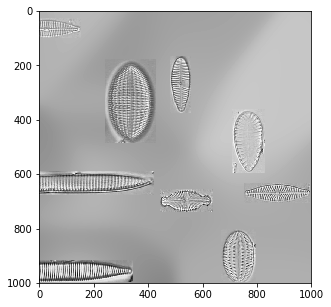

In [19]:
final_img = Generator_Img(DATASET_PATH = DATASET_PATH, simple_angles = True, size_px = 1000, fast=True)
showImg(final_img)

In [20]:
cv2.imwrite( "./yey.png", final_img)

True